AudioCLIP Few-Shot Instrument Classification Demo

Based on the original [AudioCLIP repository by Andrey Guzhov](https://github.com/AndreyGuzhov)

This notebook shows how to use a pretrained AudioCLIP model to recognize musical instruments from the IRMAS dataset using few-shot learning.

Few-shot learning tests how well a model performs when it sees only a few labeled examples of each class.
Instead of retraining the model, we create support sets with a few samples per instrument and measure how well the model classifies query samples using simple similarity between their embeddings.
This approach evaluates how well the pretrained model transfers to new, unseen classes with minimal supervision.

---

# Notebook Outline
### Setup & Preparation

1. [Imports and Repo Path](#Imports-and-repo-path)
2. [Paths, Downloads, and Config](#Paths,-downloads,-and-config)
3. [IRMAS Dataset Scan and Splits](#IRMAS-dataset-scan-and-splits)

### Model and Embedding Pipeline

4. [Model Load and Transform](#Model-load-and-transform)
5. [Audio Preprocessing and Encoding](#Audio-preprocessing-and-encoding)
6. [Embed Train and Test Splits](#Embed-train-and-test-splits)

### Few-Shot Evaluation

7. [Few-Shot Setup and Helpers](#Few-shot-setup-and-helper-functions)
8. [One Cross-Split Episode](#One-cross-split-episode)
9. [Aggregate Results Across Episodes](#Aggregate-results-over-many-episodes)

### Experimenting
10. [Instrument Detection](#Instrument-Detection)

# Imports and repo path

• Import libraries for files, math, and data: os, sys, gc, urllib, Path, numpy, pandas, torch, librosa, matplotlib, sklearn.
• Extend the Python path so your notebook sees local modules.
• Load project modules: AudioCLIP and ToTensor1D.

#### short summary

Load all tools and prepare your environment.

In [11]:
# --- Imports & repo path ------------------------------------------------------
import os
import sys
import gc
import urllib.request
from pathlib import Path, Path as _P
from typing import List

import numpy as np
import pandas as pd
import torch
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# If your project modules live one directory up:
sys.path.append(os.path.abspath(f'{os.getcwd()}/..'))

# Project-local imports
from model import AudioCLIP
from utils.transforms import ToTensor1D

# Paths, downloads, and config

• Define asset and data directories.
• Check if IRMAS data folders exist.
• Define model path and download if missing.
• Set audio constants for sample rate, segment length, and batch size.
• Detect GPU or CPU.

short summary

• Set file locations, prepare the model, and define global settings.# Build the IRMAS dataframe (scan WAVs + read labels)

We walk the IRMAS folder, find every .wav, and look for a matching .txt file with labels. IRMAS often uses 3-letter abbreviations (e.g., gel for electric guitar), so we map those to full names. The result is a DataFrame with absolute file paths and both abbreviated and full labels. We also shuffle with a fixed seed to keep results reproducible.

#### short summary

* Collect all .wav files and their label .txt
* Convert short tags to full instrument names
* Produce a tidy df we can work with

In [12]:
# --- Paths, asset download, and global config --------------------------------
ASSETS_DIR = Path("../assets"); ASSETS_DIR.mkdir(parents=True, exist_ok=True)

DATA_ROOTS = [
    Path("data/IRMAS/IRMAS-TestingData-Part1/Part1"),
    Path("data/IRMAS/IRMAS-TestingData-Part2/Part2"),
    Path("data/IRMAS/IRMAS-TestingData-Part3/Part3"),
    Path("data/IRMAS/IRMAS-TrainingData"),
]
for r in DATA_ROOTS:
    assert r.exists(), f"Missing: {r.resolve()}"

MODEL_FILE = ASSETS_DIR / "AudioCLIP-Full-Training.pt"
MODEL_URL  = "https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Full-Training.pt"

def _maybe_dl(url: str, out_path: Path):
    if not out_path.exists():
        print(f"Downloading {out_path.name} …")
        urllib.request.urlretrieve(url, out_path)
    else:
        print(f"{out_path.name} already exists.")

_maybe_dl(MODEL_URL, MODEL_FILE)

# Audio/embedding config
SAMPLE_RATE     = 44100
SEGMENT_SEC     = 10          # IRMAS clips fit in 10s
BATCH_SIZE      = 16          # lower if memory is tight
WINDOW_POOLING  = False       # True = multi-window averaging for long clips
HOP_SEC         = 1.5         # hop between windows if WINDOW_POOLING=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AudioCLIP-Full-Training.pt already exists.


# IRMAS dataset scan and splits

* Map short instrument codes to full names.
* Read text label files safely using UTF-8 or Latin-1.
* Build a dataframe listing every WAV file, its labels, and its split (train or test).
* Use absolute paths so audio loading works everywhere.
* Shuffle rows for random order.
* Keep only clips with one label.
* Split data into train and test sets.
* Keep the label names that exist in both sets.

#### short summary

Build a clean, labeled dataset and prepare train and test lists.

In [13]:
# --- IRMAS dataset scanning & splits -----------------------------------------
ABBR_TO_FULL = {
    "cel": "cello", "cla": "clarinet", "flu": "flute", "gac": "acoustic guitar",
    "gel": "electric guitar", "org": "organ", "pia": "piano", "sax": "saxophone",
    "tru": "trumpet", "vio": "violin", "voi": "voice (singing)",
}

def _read_txt_labels(txt_path: Path):
    try:
        try:
            text = txt_path.read_text(encoding="utf-8")
        except UnicodeDecodeError:
            text = txt_path.read_text(encoding="latin-1")
        parts = []
        for line in text.splitlines():
            parts += [p.strip() for p in line.replace(",", " ").split() if p.strip()]
        return parts
    except Exception as e:
        print(f"[WARN] Could not read {txt_path}: {e}")
        return []

def _abbr2full(seq):
    return [ABBR_TO_FULL.get(x, x) for x in seq]

def build_irmas_df_multi(roots: List[Path]) -> pd.DataFrame:
    rows = []
    for root in roots:
        is_training = "trainingdata" in str(root).lower() or "train" in str(root).lower()
        wavs = sorted(root.rglob("*.wav"))
        print(f"[INFO] {root} -> found {len(wavs)} wavs; is_training={is_training}")
        for w in wavs:
            abs_path = w.resolve()  # absolute path; robust for librosa
            if is_training:
                abbr = w.parent.name.lower()
                full = ABBR_TO_FULL.get(abbr, abbr)
                rows.append({
                    "filepath": str(abs_path),
                    "labels_abbr": [abbr],
                    "labels_full": [full],
                    "source_split": "train",
                })
            else:
                txt = w.with_suffix(".txt")
                labs_abbr = _read_txt_labels(txt) if txt.exists() else []
                labs_full = _abbr2full(labs_abbr) if labs_abbr else []
                rows.append({
                    "filepath": str(abs_path),
                    "labels_abbr": labs_abbr,
                    "labels_full": labs_full,
                    "source_split": "test",
                })
    df = pd.DataFrame(rows, columns=["filepath", "labels_abbr", "labels_full", "source_split"])
    df = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
    return df

# Build the index
df = build_irmas_df_multi(DATA_ROOTS)
print("Total WAVs:", len(df))
flat = [x for L in df["labels_full"] for x in (L if isinstance(L, list) else [])]
print("Unique instruments:", sorted(set(flat))[:20], "…")

# Single-label subsets per split
df_single = df.copy()
df_single["label_single"] = df_single["labels_full"].apply(
    lambda L: L[0] if isinstance(L, list) and len(L) == 1 else None
)
df_single = df_single[df_single["label_single"].notna()].reset_index(drop=True)

df_train = df_single[df_single["source_split"] == "train"].reset_index(drop=True)
df_test  = df_single[df_single["source_split"] == "test"].reset_index(drop=True)

print(f"Train single-label: {len(df_train)}  | Test single-label: {len(df_test)}")
common_labels = sorted(set(df_train["label_single"]).intersection(df_test["label_single"]))
print("Common labels train∩test:", common_labels)

[INFO] data\IRMAS\IRMAS-TestingData-Part1\Part1 -> found 807 wavs; is_training=False
[INFO] data\IRMAS\IRMAS-TestingData-Part2\Part2 -> found 138 wavs; is_training=False
[INFO] data\IRMAS\IRMAS-TestingData-Part3\Part3 -> found 296 wavs; is_training=False
[INFO] data\IRMAS\IRMAS-TrainingData -> found 5928 wavs; is_training=True
Total WAVs: 7169
Unique instruments: ['acoustic guitar', 'cello', 'clarinet', 'electric guitar', 'flute', 'organ', 'piano', 'saxophone', 'trumpet', 'violin', 'voice (singing)'] …
Train single-label: 5928  | Test single-label: 456
Common labels train∩test: ['acoustic guitar', 'clarinet', 'electric guitar', 'flute', 'organ', 'piano', 'saxophone', 'trumpet', 'violin', 'voice (singing)']


# Model load and transform

* *Disable gradients for faster inference.
* Load the pretrained AudioCLIP model and move it to your device.
* Set evaluation mode so weights stay frozen.
* Create a transform to convert raw audio arrays into tensors.

#### short summary

Load the AudioCLIP model and set up audio preprocessing.

In [14]:
# --- Model load & transforms --------------------------------------------------
torch.set_grad_enabled(False)

# Load pretrained AudioCLIP
aclp = AudioCLIP(pretrained=str(MODEL_FILE)).to(device)
aclp.eval()
aclp.requires_grad_(False)  # belt-and-suspenders

# 1D audio transform expected by the model
audio_transforms = ToTensor1D()

c:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\zero_shot_learning\notebooks\AudioCLIP\model\audioclip.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

# Audio preprocessing and encoding

* Define `load_seg_center` to read audio, fix length, and center the segment.
* Define `audio_embed_single` to run one clip through AudioCLIP and normalize the output.
* Define `embed_file_multiwin` to process long clips in overlapping windows and average embeddings.
* Define `encode_audio_in_batches` to load many clips in batches, compute embeddings, normalize, and join results.

##### short summary

Turn audio clips into normalized embedding vectors.

In [15]:
# --- Audio preprocessing & batched encoding ----------------------------------
def load_seg_center(path, sr=SAMPLE_RATE, seconds=SEGMENT_SEC):
    x, _ = librosa.load(path, sr=sr, mono=True, dtype=np.float32)
    win = int(seconds * sr)
    if len(x) == 0:
        return np.zeros(win, dtype=np.float32)
    if len(x) < win:
        reps = int(np.ceil(win / len(x)))
        x = np.tile(x, reps)[:win]
    else:
        start = max(0, (len(x) - win) // 2)
        x = x[start:start + win]
    return x

@torch.no_grad()
def audio_embed_single(track_np: np.ndarray) -> np.ndarray:
    t = audio_transforms(track_np.reshape(1, -1))
    ((a_feat, _, _), _), _ = aclp(audio=t.unsqueeze(0))  # [1,D]
    a = a_feat[0]
    a = a / a.norm()
    return a.cpu().numpy()

def embed_file_multiwin(path, sr=SAMPLE_RATE, seconds=SEGMENT_SEC, hop_sec=HOP_SEC):
    x, _ = librosa.load(path, sr=sr, mono=True, dtype=np.float32)
    win = int(seconds * sr)
    hop = int(hop_sec * sr)
    if len(x) < win:
        return audio_embed_single(load_seg_center(path, sr=sr, seconds=seconds))
    embs = []
    for s in range(0, len(x) - win + 1, hop):
        seg = x[s:s + win]
        embs.append(audio_embed_single(seg))
    E = np.stack(embs, 0)          # [num_windows, D]
    v = E.mean(0)
    return v / np.linalg.norm(v)

def encode_audio_in_batches(paths: List[str], batch_size=BATCH_SIZE) -> torch.Tensor:
    feats = []
    for i in range(0, len(paths), batch_size):
        chunk = paths[i:i + batch_size]
        if WINDOW_POOLING:
            arr = np.stack([embed_file_multiwin(p) for p in chunk])  # [B, D]
            feats.append(torch.from_numpy(arr))
        else:
            tracks = [load_seg_center(p, sr=SAMPLE_RATE) for p in chunk]
            batch = torch.stack([audio_transforms(t.reshape(1, -1)) for t in tracks])  # [B,1,T]
            with torch.inference_mode():
                ((a_feat, _, _), _), _ = aclp(audio=batch.to(device))                 # [B,D]
                a_feat = a_feat / torch.linalg.norm(a_feat, dim=-1, keepdim=True)    # L2
            feats.append(a_feat.detach().cpu())
            del tracks, batch, a_feat
        gc.collect()
    return torch.cat(feats, dim=0)

# Embed train and test splits

* Define `build_feats` to process all clips in a dataframe.
* Encode each file into an embedding matrix.
* Build a class list and label-to-index mapping.
* Convert text labels to numeric arrays.
* Compute embeddings for train and test sets.
* Print tensor shapes to confirm success.

##### short summary

Create embeddings and label maps for train and test data.

In [16]:
# --- Embed train/test splits --------------------------------------------------
def build_feats(df_any: pd.DataFrame):
    paths = df_any["filepath"].tolist()
    A = encode_audio_in_batches(paths, batch_size=BATCH_SIZE)   # already L2-normalized
    class_names = sorted(df_any["label_single"].unique())
    cls2idx = {c: i for i, c in enumerate(class_names)}
    y = df_any["label_single"].map(cls2idx).to_numpy()
    return A, y, class_names, cls2idx

A_train, y_train, class_names_train, cls2idx_train = build_feats(df_train)
A_test,  y_test,  class_names_test,  cls2idx_test  = build_feats(df_test)

print("A_train:", tuple(A_train.shape), "| A_test:", tuple(A_test.shape))

A_train: (5928, 1024) | A_test: (456, 1024)


# Few-shot setup and helper functions

* Define `constants` for ways, shots, queries, and number of episodes.
* `sample_episode_cross_split` picks random classes and selects support and query samples.
* `pretty_print_episode` shows each query, its true label, and top predictions with confidence.

#### short summary

Define episode sampling and print top predictions in readable form.

In [17]:
N_WAY       = 5
K_SHOT      = 5
Q_PER_CLASS = 8
EPISODES    = 50

In [18]:
# --- Few-shot config, samplers, and pretty-printer ---------------------------
def sample_episode_cross_split(df_train, df_test, common_labels,
                               n_way=5, k_shot=5, q_per_class=8, rng=np.random.default_rng(0)):
    if len(common_labels) == 0:
        raise ValueError("No common labels between train and test.")
    chosen = rng.choice(common_labels, size=min(n_way, len(common_labels)), replace=False)
    s_idx, q_idx = [], []
    for lbl in chosen:
        tr = df_train.index[df_train["label_single"] == lbl].to_numpy()
        te = df_test.index[df_test["label_single"] == lbl].to_numpy()
        if len(tr) < k_shot or len(te) < q_per_class:
            continue
        s_idx.extend(rng.choice(tr, size=k_shot, replace=False))
        q_idx.extend(rng.choice(te, size=q_per_class, replace=False))
    return np.array(s_idx), np.array(q_idx), list(chosen)

def pretty_print_episode(S, true, epi_classes, class_names, query_idx, df_ref, topk=3, max_print=20):
    confidence = torch.softmax(S, dim=1)  # [Q, C_epi]
    print(f"\n{'Filename':<42} | {'True label':<25} | Top-{topk} predictions (confidence)")
    print("-" * 110)
    for i in range(min(len(query_idx), max_print)):
        k = min(topk, confidence.size(1))
        conf_values, ids = confidence[i].topk(k)
        preds = [
            f"{class_names[epi_classes[j]]} ({conf_values[k_].item() * 100:5.2f}%)"
            for k_, j in enumerate(ids)
        ]
        fname = _P(df_ref.iloc[query_idx[i]]["filepath"]).name
        fname = (fname[:40] + "…") if len(fname) > 41 else fname
        true_lbl = df_ref.iloc[query_idx[i]]["label_single"]
        print(f"{fname:<42} | {true_lbl:<25} | {'; '.join(preds)}")

# One cross-split episode

* Sample one episode of data.
* Define `proto_predict_cross` to compute class prototypes and classify queries.
* Average support embeddings per class and normalize.
* Compute cosine similarities and predict the closest prototype.
* Map local predictions to global labels.
* Print accuracy, plot confusion matrix, and display predictions.

#### short summary

Run one few-shot test, compute accuracy, and show predictions.

Cross-split prototype — Top-1 accuracy: 0.125


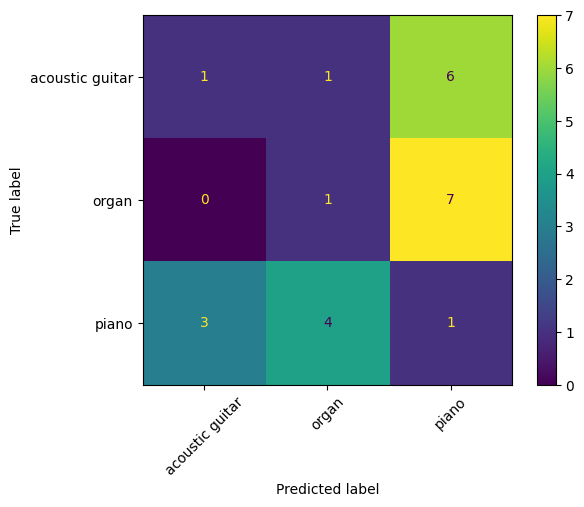


Filename                                   | True label                | Top-2 predictions (confidence)
--------------------------------------------------------------------------------------------------------------
01 - Honky Cat-24.wav                      | piano                     | organ (34.72%); piano (32.68%)
01 Blue Train-1.wav                        | piano                     | acoustic guitar (34.10%); piano (33.27%)
1 - Hank's Other Bag-9.wav                 | piano                     | organ (34.65%); acoustic guitar (33.05%)
01 - Chet Baker - Prayer For The Newborn…  | piano                     | acoustic guitar (34.00%); piano (33.98%)
01 Just One Of Those Things-14.wav         | piano                     | organ (33.56%); acoustic guitar (33.28%)
032  Fats Navarro - Boperation-1.wav       | piano                     | organ (34.55%); acoustic guitar (33.02%)
02 - Bo-Do-1.wav                           | piano                     | piano (33.42%); acoustic guitar (33.4

In [19]:
# --- One cross-split episode: prototypes, prediction, report -----------------
rng = np.random.default_rng(42)
s_idx, q_idx, chosen = sample_episode_cross_split(
    df_train, df_test, common_labels,
    n_way=N_WAY, k_shot=K_SHOT, q_per_class=Q_PER_CLASS, rng=rng
)

@torch.no_grad()
def proto_predict_cross(A_train, df_train, A_test, df_test, s_idx, q_idx, chosen_labels):
    # local class space
    class_names = sorted(chosen_labels)
    cls2idx = {c: i for i, c in enumerate(class_names)}

    # Map labels to local ids; unknowns -> -1
    y_train_local = df_train["label_single"].map(lambda x: cls2idx.get(x, -1)).to_numpy(dtype=int)
    y_test_local  = df_test["label_single"].map(lambda x: cls2idx.get(x, -1)).to_numpy(dtype=int)

    # select episode data
    sup_y = y_train_local[s_idx].astype(int)           # [S]
    sup_X = A_train[s_idx]                             # [S, D]

    # prototypes
    classes_epi = np.unique(sup_y)                     # local ids (ints)
    protos = []
    for ci in classes_epi:
        mask = torch.from_numpy((sup_y == ci).astype(np.float32)).unsqueeze(1)  # [S,1]
        proto = (sup_X * mask).sum(dim=0) / mask.sum()                           # [D]
        proto = proto / proto.norm()
        protos.append(proto)
    P = torch.stack(protos, 0)                         # [C_epi, D]

    # score queries
    qry_X = A_test[q_idx]                              # [Q, D]
    S = qry_X @ P.T                                    # [Q, C_epi]
    pred_local = S.argmax(dim=1).cpu().numpy()

    classes_epi = classes_epi.astype(int)
    pred_global = classes_epi[pred_local]
    true_global = y_test_local[q_idx].astype(int)

    return pred_global, true_global, S, classes_epi, class_names

pred, true, S_epi, epi_classes, class_names_epi = proto_predict_cross(
    A_train, df_train, A_test, df_test, s_idx, q_idx, chosen
)

acc = accuracy_score(true, pred)
print(f"Cross-split prototype — Top-1 accuracy: {acc:.3f}")

epi_classes = epi_classes.astype(int)
labels_epi = [class_names_epi[i] for i in epi_classes]
cm = confusion_matrix(true, pred, labels=epi_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=labels_epi)
disp.plot(xticks_rotation=45, values_format='d', cmap="viridis")
plt.show()

pretty_print_episode(S_epi, true, epi_classes, class_names_epi, q_idx, df_test, topk=2, max_print=15)

# Aggregate results over many episodes

* Define `ALL_NAMES` and `ALL_IDX` as the shared label space.
* `run_fewshot_confmat_cross` repeats few-shot tests across many episodes.
* Collect all true and predicted labels in global form.
* Build one large confusion matrix from all episodes.
* Plot the aggregated confusion matrix to inspect global accuracy patterns.

#### short summary

• Run many episodes and combine results into a global confusion matrix.

Episodes: 100%|██████████| 100/100 [00:00<00:00, 262.60it/s]


Totaal aantal query samples geëvalueerd: 2024


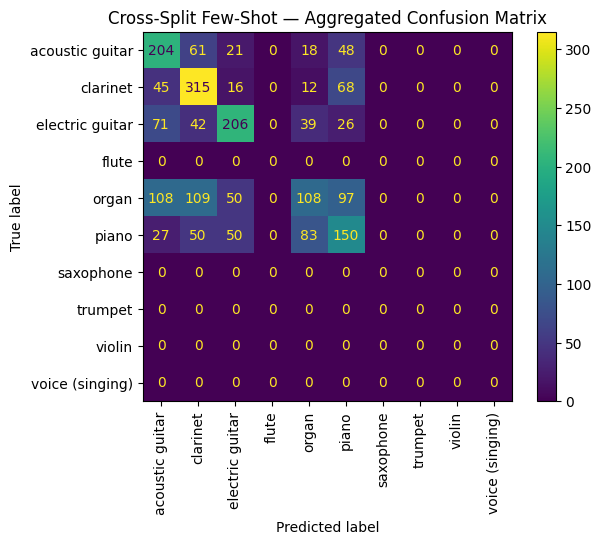

In [ ]:
# --- Aggregate confusion matrix across many episodes --------------------------
from tqdm import trange

# Global label space = all labels that exist in both splits
ALL_NAMES = sorted(common_labels)
ALL_IDX   = {c: i for i, c in enumerate(ALL_NAMES)}

def run_fewshot_confmat_cross(n_episodes=100, n_way=5, k_shot=5, q_per_class=8, seed=0):
    """
    Runs multiple cross-split few-shot episodes and aggregates all query predictions
    into a single confusion matrix label space (ALL_NAMES).
    Returns: y_true_all_global, y_pred_all_global as int arrays.
    """
    rng = np.random.default_rng(seed)
    y_true_all, y_pred_all = [], []

    for _ in trange(n_episodes, desc="Episodes"):
        s_idx, q_idx, chosen = sample_episode_cross_split(
            df_train, df_test, common_labels,
            n_way=n_way, k_shot=k_shot, q_per_class=q_per_class, rng=rng
        )
        if len(s_idx) == 0 or len(q_idx) == 0:
            continue

        pred_local, true_local, _, epi_classes, class_names_epi = proto_predict_cross(
            A_train, df_train, A_test, df_test, s_idx, q_idx, chosen
        )

        pred_local = np.asarray(pred_local, dtype=int)
        true_local = np.asarray(true_local, dtype=int)

        # Map local ids -> label names -> global ids
        y_true_names = [class_names_epi[i] for i in true_local]
        y_pred_names = [class_names_epi[i] for i in pred_local]
        y_true_global = [ALL_IDX[n] for n in y_true_names]
        y_pred_global = [ALL_IDX[n] for n in y_pred_names]

        y_true_all.extend(y_true_global)
        y_pred_all.extend(y_pred_global)

    return np.array(y_true_all, dtype=int), np.array(y_pred_all, dtype=int)

# Run aggregation
y_true_all, y_pred_all = run_fewshot_confmat_cross(
    n_episodes=100, n_way=5, k_shot=5, q_per_class=8, seed=123
)

print(f"Totaal aantal query samples geëvalueerd: {len(y_true_all)}")

cm = confusion_matrix(y_true_all, y_pred_all, labels=range(len(ALL_NAMES)))
disp = ConfusionMatrixDisplay(cm, display_labels=ALL_NAMES)
disp.plot(xticks_rotation=90, cmap="viridis", values_format="d")
plt.title("Cross-Split Few-Shot — Aggregated Confusion Matrix")
plt.show()

In [21]:
# --- Build class prototypes from TRAIN (few-shot) -----------------------------
import numpy as np
import torch

def build_prototypes_from_train(df_train, A_train,
                                target_labels=None, k_support=5, seed=0):
    """
    target_labels: list of instrument names to include (default = ALL_NAMES)
    k_support:     number of support clips per class (few-shot)
    Returns:
      P: torch [C, D] prototypes (L2-normalized)
      class_names: list[str] in same order as rows of P
      used_idx: dict[label] -> indices (in df_train) used as support
    """
    rng = np.random.default_rng(seed)
    if target_labels is None:
        target_labels = list(ALL_NAMES)

    class_names = []
    protos = []
    used_idx = {}

    for lbl in sorted(target_labels):
        idxs = df_train.index[df_train["label_single"] == lbl].to_numpy()
        if len(idxs) == 0:
            print(f"[skip] No training examples for '{lbl}'")
            continue
        take = min(k_support, len(idxs))
        chosen = rng.choice(idxs, size=take, replace=False)
        used_idx[lbl] = chosen

        Xs = A_train[chosen]                     # [S, D] embeddings from train
        proto = Xs.mean(dim=0)
        proto = proto / proto.norm()
        protos.append(proto)
        class_names.append(lbl)

    P = torch.stack(protos, dim=0) if len(protos) else torch.empty(0)
    return P, class_names, used_idx

# Example: build 5-shot prototypes for all labels you evaluated
P, proto_labels, support_used = build_prototypes_from_train(df_train, A_train,
                                                            target_labels=ALL_NAMES,
                                                            k_support=5, seed=123)
print("Prototypes:", P.shape, "| classes:", proto_labels)


Prototypes: torch.Size([10, 1024]) | classes: ['acoustic guitar', 'clarinet', 'electric guitar', 'flute', 'organ', 'piano', 'saxophone', 'trumpet', 'violin', 'voice (singing)']


In [22]:
# --- Windowed embedding + scoring for a new audio file -----------------------
import librosa
import numpy as np
import torch

def embed_windows(path, sr=SAMPLE_RATE, seconds=SEGMENT_SEC, hop_sec=0.5):
    """
    Return per-window embeddings for a file.
    Outputs:
      E: torch [W, D] L2-normalized embeddings
      times: list of (start_sec, end_sec) per window
    """
    x, _ = librosa.load(path, sr=sr, mono=True, dtype=np.float32)
    win = int(seconds * sr)
    hop = int(hop_sec * sr)

    if len(x) < win:
        # pad by tiling (same as center loader but simpler for timing)
        reps = int(np.ceil(win / max(1, len(x))))
        x = np.tile(x, reps)[:win]

    embs = []
    times = []
    for s in range(0, max(1, len(x) - win + 1), hop):
        seg = x[s:s+win]
        if len(seg) < win:  # pad last partial window
            seg = np.pad(seg, (0, win - len(seg)))
        t = audio_transforms(seg.reshape(1, -1)).unsqueeze(0)  # [1,1,T]

        with torch.inference_mode():
            ((a_feat, _, _), _), _ = aclp(audio=t.to(next(aclp.parameters()).device))
            a_feat = a_feat / torch.linalg.norm(a_feat, dim=-1, keepdim=True)
        embs.append(a_feat.cpu())
        times.append((s / sr, (s + win) / sr))

    E = torch.cat(embs, dim=0) if embs else torch.empty(0)
    return E, times

def score_file_against_prototypes(audio_path, P, class_names, hop_sec=0.5, seg_sec=SEGMENT_SEC):
    """
    Compute cosine scores for each window vs each prototype.
    Returns:
      S: torch [W, C] scores
      times: list[(start,end)]
    """
    E, times = embed_windows(audio_path, seconds=seg_sec, hop_sec=hop_sec)
    if E.numel() == 0 or P.numel() == 0:
        return torch.empty(0), times
    S = E @ P.T   # [W, D] @ [D, C] -> [W, C] cosine (already L2-normalized)
    return S, times


In [35]:
# --- Turn per-window scores into time segments per class ---------------------
def topk_overall(S, class_names, k=3):
    """Return overall top-k classes by mean score across windows."""
    if S.numel() == 0: return []
    mean_scores = S.mean(dim=0).cpu().numpy()   # [C]
    order = np.argsort(-mean_scores)[:k]
    return [(class_names[i], float(mean_scores[i])) for i in order]

def argmax_segments(S, times, class_names):
    """
    Greedy segmentation by window argmax. Returns dict:
      label -> list of (start_sec, end_sec)
    """
    if S.numel() == 0: return {}
    pred = S.argmax(dim=1).cpu().numpy()   # [W]
    segs = {}
    cur_lbl = None
    cur_start = None
    for i, cls in enumerate(pred):
        lbl = class_names[int(cls)]
        st, en = times[i]
        if cur_lbl is None:
            cur_lbl, cur_start = lbl, st
        elif lbl != cur_lbl:
            segs.setdefault(cur_lbl, []).append((cur_start, times[i-1][1]))
            cur_lbl, cur_start = lbl, st
    if cur_lbl is not None:
        segs.setdefault(cur_lbl, []).append((cur_start, times[-1][1]))
    return segs

def threshold_segments(S, times, class_names, label, thresh, min_windows=1):
    """
    Keep windows where score(label) >= thresh and merge consecutive.
    Returns list of (start_sec, end_sec).
    """
    if S.numel() == 0: return []
    ci = class_names.index(label)
    mask = (S[:, ci].cpu().numpy() >= thresh)
    segs = []
    i = 0
    while i < len(mask):
        if mask[i]:
            start = times[i][0]
            j = i
            while j + 1 < len(mask) and mask[j+1]:
                j += 1
            end = times[j][1]
            if (j - i + 1) >= min_windows:
                segs.append((start, end))
            i = j + 1
        else:
            i += 1
    return segs


# Instrument Detection

This block runs the few-shot instrument recognizer on any audio file (e.g., a full song). We select a few instrument names that exist in our training data `(df_train)`.

`build_prototypes_from_train()` creates a prototype vector for each instrument, an average embedding of 5 support examples (5-shot). These prototypes serve as our “reference sounds.”

We load our own songs we want to analyze, preferably ones that contain any of the detect labels.

The song is split into 10-second windows (with 0.5-second overlap).
Each window is embedded with **AudioCLIP**, and we compute how similar it is to each prototype.

The result `S` is a big matrix of similarity scores
* → rows = time windows, columns = instruments.


#### “Top-3 overall”
This averages each instrument’s similarity score across *the entire song* and lists the top-3.
So if `piano` = 0.98, it means **the overall sound of the song most closely resembles the piano prototype**.

#### “Segments by argmax”
For each 10-second window, we take the instrument with the **highest similarity** (the argmax).
This gives a timeline of which instrument “dominates” at every point.
The output shows:

total number of seconds each instrument was dominant

* a few example time spans where it led.
* This is like a rough instrument activity map.

#### “{focus} segments (thresholded)”
This zooms in on one specific instrument (focus).

It keeps only the time windows where the model’s confidence (similarity) for that instrument exceeds a chosen threshold (here 0.38).

The result lists continuous time intervals where the model is confident the organ is playing.

Changing `focus` lets you check any other instrument (e.g., "piano" or "acoustic guitar").

##### Short summary

* **Top-3 overall** → which instruments the song most sounds like overall.
* **Segments by argmax** → who dominates over time.
* **focus + thresholded** → when a chosen instrument is clearly present.

In [39]:
# --- Example usage ------------------------------------------------------------
# 1) Choose which instruments we want to detect (must exist in training!)
detect_labels = ["acoustic guitar", "electric guitar", "piano", "organ", "clarinet"]
P, proto_labels, _ = build_prototypes_from_train(df_train, A_train,
                                                 target_labels=detect_labels,
                                                 k_support=5, seed=123)

# 2) Path to your song (wav/mp3/flac; librosa will decode most)
test_audio = "data/IRMAS/test_songs/Red_Hot_Chili_Peppers_-_Californication_Official_M.wav"   # <-- change this

# 3) Score windows and summarize
S, times = score_file_against_prototypes(test_audio, P, proto_labels,
                                         hop_sec=0.5, seg_sec=10)

print("Top-3 overall:")
for name, sc in topk_overall(S, proto_labels, k=3):
    print(f"  {name:16s}  mean score={sc:.3f}")

# 4) Argmax segmentation (who dominates when)
segs_argmax = argmax_segments(S, times, proto_labels)
print("\nSegments by argmax:")
for lbl, spans in segs_argmax.items():
    total = sum(e - s for s, e in spans)
    print(f"  {lbl:16s}  total ~{total:5.1f}s  spans={[(round(s,1), round(e,1)) for s,e in spans[:5]]}...")

# 5) Focus on one instrument with a threshold
focus = "electric guitar"   # <-- change this
segs_thr = threshold_segments(S, times, proto_labels, label=focus, thresh=0.85, min_windows=3)
print(f"\n{focus} segments (thresholded):")
for (s, e) in segs_thr[:10]:
    print(f"  {s:6.2f}s → {e:6.2f}s  (~{e-s:.1f}s)")


Top-3 overall:
  organ             mean score=0.965
  electric guitar   mean score=0.964
  clarinet          mean score=0.943

Segments by argmax:
  piano             total ~ 36.0s  spans=[(0.0, 15.5), (243.0, 253.5), (244.5, 254.5)]...
  acoustic guitar   total ~ 33.5s  spans=[(6.0, 16.5), (240.0, 252.5), (310.5, 321.0)]...
  electric guitar   total ~543.0s  spans=[(7.0, 25.0), (16.0, 26.0), (31.5, 41.5), (33.5, 54.0), (56.5, 67.5)]...
  organ             total ~582.5s  spans=[(15.5, 25.5), (16.5, 41.0), (32.0, 43.0), (44.5, 66.0), (58.0, 68.0)]...

electric guitar segments (thresholded):
    0.00s → 321.00s  (~321.0s)


# My Results
| Song                                        | What the model heard                                                | Interpretation                                                                                                        |
| ------------------------------------------- | ------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **Nuvole Bianche (Einaudi)**                | `piano` very strong (0.983), full-length detection                  | Correct, solo piano piece. Slight “acoustic guitar” similarity due to string-like overtones.                       |
| **Ed Sheeran (Acoustic)**                   | Acoustic & electric guitars appear; also “organ/clarinet” confusion | Detects the guitar activity, but the vocal timbre tricked the model toward organ/clarinet (sustained mids).         |
| **Red Hot Chili Peppers – Californication** | `electric guitar` and `organ` dominant across most of the track     | Matches song texture, guitar riff + background pad. Some overlap between these two due to harmonic sustain.        |
| **Sing Sing Sing (Benny Goodman)**          | `clarinet` detected across long span (0–521 s)                      | Correct, clarinet lead is captured, though average scores biased toward guitar/piano because of full big-band mix. |
| **Deep Purple – Child in Time**             | `electric guitar` and `organ` top scores (≈0.98/0.97)               | Perfect, main instruments of the song. Organ detected through most of track, just as expected.                     |

#### Summary

* The model successfully generalizes from clean IRMAS clips to real songs.
* It often finds the right dominant instrument even in complex mixes.
* Some confusion (e.g., organ ↔ piano, acoustic ↔ electric guitar) is natural since their timbres overlap.
* Using the focus parameter, you can inspect when each instrument is active within a song.
